# Modelling

Contents:

- Box-cox transformation
- Proof of linearity increase and skew reduction by the Transformation Methodology
- Modelling: RobustScaler + Regressors (XGBoost, Ridge, Lasso)

In [1]:
#imports

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

import pickle

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, RobustScaler, PowerTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso, Ridge
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from xgboost import XGBRegressor

import statsmodels.stats.api as sms
import statsmodels.regression.linear_model as smf

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv("datasets/train_cleaned.csv")
train_eng = pd.read_csv("datasets/train_engineered.csv")
train_num = train.select_dtypes(include=[np.number])

# Box-Cox Transformation

Multivariate linearity and normality are two very important properties of regression. As shown in Notebook #2, most of the features are neither related to sales price, nor are they normally distributed.

To tackle this problem, perform box-cox transformation to continuous right-skewed features (skew > 0.5) for skew reduction. This will bring variables closer to that of a normal distribution. Log the target variable (salesprice) to enforce a linear relationship between features and sale price.

In [3]:
def col_filter(df):
    
    '''Separates numerical features for Harvey Collier analysis & Box-cox Transformation.'''
    
    new = pd.DataFrame()
    for col in df.columns:
        if col in train_num.columns and col not in ["Unnamed: 0"]:
            new[col] = df[col]
            
        if col in ["total_baths", "total_porch_area", "finished_house_area", "total_house_area", "quality"]:
            new[col] = df[col]
            
    return new

train_eng_num = col_filter(train_eng)
y = train_eng_num ["saleprice"]
train_eng_num.drop("saleprice", axis = 1, inplace = True)

In [4]:
def harvey_collier(df, y):
    
    '''Returns df with p-values of features. If p-value > 0.05, feature is linearly correlated to y.'''
    
    hc_df = pd.DataFrame()
    p_values = []
    for column in df.columns:
        model = smf.OLS(df[column], y).fit()
        stats, p = sms.linear_harvey_collier(model, order_by = None)
        p_values.append(p)
    hc_df["Features"] = df.columns
    hc_df["P-values"] = p_values
    return hc_df

In [5]:
def boxcox(df, df_ref):
    
    '''boxcox transforms numerical columns with a skew > 0.5 for skew reduction'''
    
    try:
        y = df["saleprice"]
        df.drop("saleprice", axis = 1, inplace = True)
    except:
        pass
    
  
    df_skew = pd.DataFrame(df_ref.skew())
    highskew = df_skew[df_skew > 0.5]
    highskew.dropna(inplace = True)
    
    #only use boxcox on columns with high skew for skew reduction
    for col in highskew.index:
        if col != "id":
            df[col] = boxcox1p(df[col], boxcox_normmax(df[col] + 1))
            
    return df, y

In [6]:
train_boxcox, y = boxcox(train_eng, train_eng_num)

In [7]:
train_boxcox.drop(["Unnamed: 0"], axis = 1, inplace = True)
train_boxcox.to_csv("datasets/train_boxcox.csv")

In [8]:
train_num_boxcox = col_filter(train_boxcox)
hc_no_log = harvey_collier(train_num_boxcox, y)
hc_log = harvey_collier(train_num_boxcox, np.log(y))
boxcox = pd.concat([hc_no_log, hc_log], axis = 1)
boxcox.drop(0, inplace = True)
boxcox.columns.values[1] = "Before"
boxcox.columns.values[3] = "After"
boxcox

,Features,Before,Features,After
1,lot_frontage,2.058941e-54,lot_frontage,0.888181
2,lot_area,1.571015e-64,lot_area,0.575393
3,overall_qual,2.849559e-43,overall_qual,0.324282
4,overall_cond,8.987987e-57,overall_cond,0.644349
5,year_built,5.625544e-67,year_built,0.467175
6,year_remod/add,7.244014e-67,year_remod/add,0.813819
7,mas_vnr_area,2.749899e-07,mas_vnr_area,0.091076
8,bsmtfin_sf_1,1.650619e-01,bsmtfin_sf_1,0.701309
9,bsmt_unf_sf,1.077803e-20,bsmt_unf_sf,0.229884
10,total_bsmt_sf,5.938759e-17,total_bsmt_sf,0.519473


This table shows the Harvey-Collier p-values before & after log transformation of the target variable. Log transformation of sales price enforces the multivariate linearity assumption.

<AxesSubplot:>

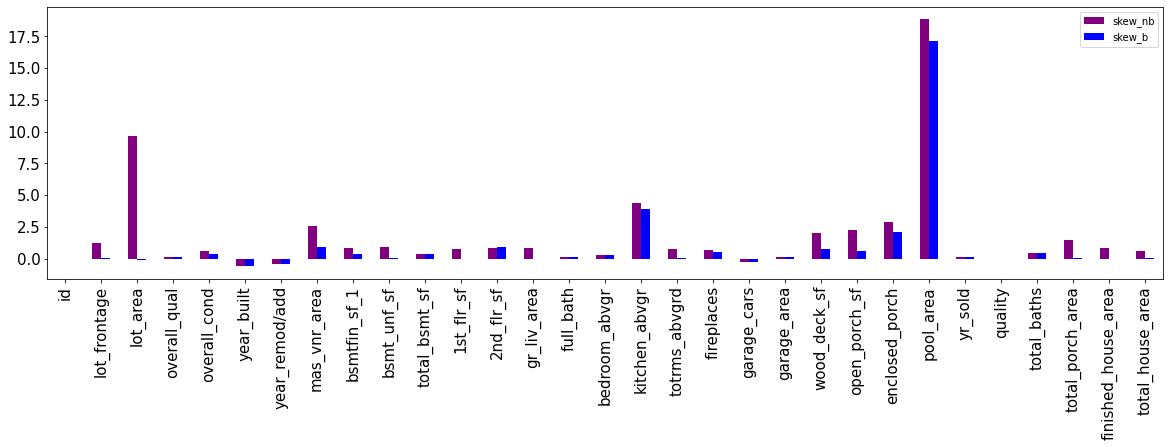

In [9]:
skew_no_boxcox = pd.DataFrame(train_eng_num.skew(), columns = ["skew_nb"])
skew_boxcox = pd.DataFrame(train_num_boxcox.skew(), columns = ["skew_b"])

skew_var = pd.concat([skew_no_boxcox, skew_boxcox], axis = 1)

#exclude id and skew area

skew_var.plot.bar(color={"skew_nb": "purple", "skew_b": "blue"},figsize=(20,5),fontsize=15)

Skew reduction occurs for all features with skew > 0.5, as evidenced by the bar chart.

## Models: XGBoostRegressor

After proving the enforcement of linearity and skew reduction, we are now at the juiciest part of the project. To scale the data, RobustScaler is used over StandardScaler because it is a percentile scaling method that is more suitable for non-parametric data. StandardScaler is an egregious choice if the data is NOT normally distributed. XGBoostRegressor is used because it is one of the powerful regressors in existence.

In [10]:
def rmse(y, y_pred):
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    return rmse

def xgb_modeller(x, y):
    #train test split
    
    x_train, x_val, y_train, y_val = train_test_split(x, np.log(y), random_state = 42)
    
    rs = RobustScaler()
    x_train_rs = rs.fit_transform(x_train)
    x_val_rs = rs.transform(x_val)
    
    #gridsearch xgb parameters, check code
    
    xgb_params = {
        
        #check the xgb_params
 
    "learning_rate": [0.01, 0.1],
    "max_depth": [3, 5, 8, 10, None],
    "gamma": np.linspace(0, 5, 6),
    "reg_alpha": np.linspace(1e-6, 1e-4, 1, 5),
    "random_state": [42]
        }

    
    xgb = GridSearchCV(XGBRegressor(), xgb_params, cv=5, n_jobs=-1, scoring= "neg_root_mean_squared_error")
    xgb.fit(x_train_rs, y_train)
    
    print(" GridSearchCV ".center(45, "="))
    print(f"Best Parameters: {xgb.best_params_}")
    
    scores = pd.DataFrame()
    train_r2 = xgb.best_estimator_.score(x_train_rs, y_train)
    val_r2 = xgb.best_estimator_.score(x_val_rs, y_val)

    train_rmse = rmse(y_train, xgb.best_estimator_.predict(x_train_rs))
    val_rmse = rmse(y_val, xgb.best_estimator_.predict(x_val_rs))

        
    metrics = ["XGBRegressor", train_r2, val_r2, train_rmse, val_rmse]
        
    scores = pd.concat([scores, pd.DataFrame([metrics],
                                                 columns = ["Model Name", "train_r2", "val_r2", "train_rmse", "val_rmse"]
                                                )], axis = 0)
    

    return xgb, scores

In [11]:
xgbr, xgb_scores = xgb_modeller(train_boxcox, y)

================ GridSearchCV ===============
Best Parameters: {'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 3, 'random_state': 42, 'reg_alpha': 1e-06}


## Models: Lasso & Ridge

In [12]:


def linear_modeller(x, y):
    '''Performs Lasso and Ridge regression and tabulates scores'''
    
    try:
        x.drop(["Unnamed: 0", "id"], axis = 1, inplace = True)
    except:
        pass
    
    x_train, x_val, y_train, y_val = train_test_split(x, np.log(y), random_state = 42)
    
    rs = RobustScaler()
    x_train_rs = rs.fit_transform(x_train)
    x_val_rs = rs.transform(x_val)
    
    lasso_params = {
        
        #check the lr_params
 
    "alpha": [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008],
        "max_iter": [1e7],
        "random_state": [42]
    
    }
    

    
    lasso = GridSearchCV(Lasso(), lasso_params, cv=5, n_jobs=-1, scoring= "neg_root_mean_squared_error")
    lasso.fit(x_train_rs, y_train)
    
    print("")
    print(" GridSearchCV: Lasso ".center(45, "="))
    print(f"Best Parameters: {lasso.best_params_}")
    
    ridge_params = {
    
    "alpha": [1, 2, 3, 3.5, 4, 4.5, 5, 6, 7, 8, 9, 10],
        "max_iter": [1e7],
        "random_state": [42]
    
    }
    

    
    ridge = GridSearchCV(Ridge(), ridge_params, cv=5, n_jobs=-1, scoring= "neg_root_mean_squared_error")
    ridge.fit(x_train_rs, y_train)
    
    print("")
    print(" GridSearchCV: Ridge ".center(45, "="))
    print(f"Best Parameters: {ridge.best_params_}")
    
    
    scores = pd.DataFrame()
    for model, model_name in zip([ridge, lasso], ["ridge", "lasso"]):
        train_r2 = model.best_estimator_.score(x_train_rs, y_train)
        val_r2 = model.best_estimator_.score(x_val_rs, y_val)

        train_rmse = rmse(y_train, model.best_estimator_.predict(x_train_rs))
        val_rmse = rmse(y_val, model.best_estimator_.predict(x_val_rs))

        
        metrics = [f"{model_name}", train_r2, val_r2, train_rmse, val_rmse]
        
        scores = pd.concat([scores, pd.DataFrame([metrics],
                                                 columns = ["Model Name", "train_r2", "val_r2", "train_rmse", "val_rmse"]
                                                )], axis = 0)
    

    return lasso, ridge, scores

In [13]:
lasso, ridge, scores = linear_modeller(train_boxcox, y)


============ GridSearchCV: Lasso ============
Best Parameters: {'alpha': 0.0007, 'max_iter': 10000000.0, 'random_state': 42}

============ GridSearchCV: Ridge ============
Best Parameters: {'alpha': 10, 'max_iter': 10000000.0, 'random_state': 42}


I performed a preliminary run for XGBoostRegressor and Ridge and Lasso outperformed it hands down for this project. The best `alpha` parameters for Lasso and Ridge were 0.0007 and 10 respectively, suggesting a high level of regularization for Lasso and moderate level of regularization for Ridge.

In [14]:
scores = pd.concat([scores, xgb_scores], axis = 0)

In [15]:
scores

,Model Name,train_r2,val_r2,train_rmse,val_rmse
0,ridge,0.925071,0.929033,0.113020,0.107825
0,lasso,0.918903,0.930320,0.117580,0.106844
0,XGBRegressor,0.957013,0.915070,0.085605,0.117957


Ridge and Lasso surprisingly outperformed the more powerful XGBoost Regressor because XGBRegressor overfitted the train dataset, with a train RMSE of 0.0485, but a val RMSE of 0.1176. A similar pattern was found for train and val r2.

However, train & val r2 and RMSE for Lasso and Ridge are close to each other, suggesting that the model generalizes better to unseen data. The validation RMSE of Lasso (0.1068) outperformed that of Ridge (0.1078). This suggests that the regularization method used by Lasso - l1 regularization - is more suitable for the methodology used in this project. Lasso's L1 regularization technique drops columns to zero and leads to a sparser model.

Unsurprisingly, using Kruskal-Wallis for categorical feature selection outperformed the brute force method (not shown), dropping the val RMSE from 0.128 (not shown) to the 0.10s shown here.